In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

data_path = os.getenv('DATA_PATH')
ambient_path = f"{data_path}/ambient"
attacks_path = f"{data_path}/attacks"

# Define the file paths
file_path_malicious = f"{attacks_path}/correlated_signal_attack_1.log"
file_path_clean = f"{attacks_path}/correlated_signal_attack_1_masquerade.log"

#file_path_malicious = f"{attacks_path}/correlated_signal_attack_2.log"
#file_path_clean = f"{attacks_path}/correlated_signal_attack_2_masquerade.log"

#file_path_malicious = f"{attacks_path}/correlated_signal_attack_3.log"
#file_path_clean = f"{attacks_path}/correlated_signal_attack_3_masquerade.log"

# For this case, the average time between attack CANIDs is in the mid-range (not very small or very large)
#file_path_malicious = f"{attacks_path}/max_engine_coolant_temp_attack.log"
#file_path_clean = f"{attacks_path}/max_engine_coolant_temp_attack_masquerade.log"

# For this case, the average time between attack CANIDs perfectly matches other IDs
#file_path_malicious = f"{attacks_path}/max_speedometer_attack_1.log"
#file_path_clean = f"{attacks_path}/max_speedometer_attack_1_masquerade.log"

In [ ]:
# Open both files for reading
with open(file_path_malicious, 'r') as file_malicious, open(file_path_clean, 'r') as file_clean:
    # Initialize a counter for malicious lines
    malicious_line_counter = 1

    # Set to store unique malicious CAN IDs
    unique_malicious_can_ids = set()

    # Loop through both files line by line
    while True:
        # Read one line from each file
        line_malicious = file_malicious.readline()
        line_clean = file_clean.readline()

        # Break the loop if we reach the end of either file
        if not line_malicious or not line_clean:
            break

        # Ignore the timestamps by taking the substring from the 24th character onwards
        line_malicious_no_timestamp = line_malicious[24:]
        line_clean_no_timestamp = line_clean[24:]

        # If the lines (without timestamps) are not equal, the line from the malicious file is a malicious line
        if line_malicious_no_timestamp != line_clean_no_timestamp:
            print(f'{malicious_line_counter}. {line_malicious.strip()}')
            malicious_line_counter += 1
            # Extract the CAN ID from the malicious line and add it to the set
            can_id = line_malicious.split()[2].split('#')[0]
            unique_malicious_can_ids.add(can_id)
            # Read the next line from the malicious file to re-sync the files
            line_malicious = file_malicious.readline()

# Print the unique malicious CAN IDs
print(f'\nUnique Malicious CAN IDs ({len(unique_malicious_can_ids)}):')
for can_id in unique_malicious_can_ids:
    print(can_id)

In [ ]:
from collections import defaultdict
import re

# Dictionary to store the last timestamp for each CAN ID
last_timestamps = defaultdict(float)

# Dictionary to store the sum of time differences and count of occurrences for each CAN ID
time_diff_sums_counts = defaultdict(lambda: [0, 0])  # [sum of time differences, count of occurrences]

# Regular expression to extract the timestamp and CAN ID from each line
regex = re.compile(r"\((\d+\.\d+)\) can\d+ (\w+)#.*")

# Open the malicious file for reading
with open(file_path_malicious, 'r') as file_malicious:
    # Loop through each line in the file
    for line in file_malicious:
        # Use the regex to extract the timestamp and CAN ID
        match = regex.match(line)
        if match:
            timestamp, can_id = match.groups()
            timestamp = float(timestamp)

            # If this is not the first occurrence of this CAN ID
            if last_timestamps[can_id]:
                # Update the sum of time differences and count of occurrences for this CAN ID
                time_diff_sums_counts[can_id][0] += timestamp - last_timestamps[can_id]
                time_diff_sums_counts[can_id][1] += 1

            # Update the last timestamp for this CAN ID
            last_timestamps[can_id] = timestamp

# Dictionary to store the average time difference for each CAN ID
average_time_diffs = {can_id: sum_diffs / count if count else 0 for can_id, (sum_diffs, count) in time_diff_sums_counts.items()}

# Print the average time difference for each CAN ID
for can_id, avg_time_diff in average_time_diffs.items():
    print(f'CAN ID: {can_id}, Average Time Difference: {avg_time_diff:.6f} seconds')

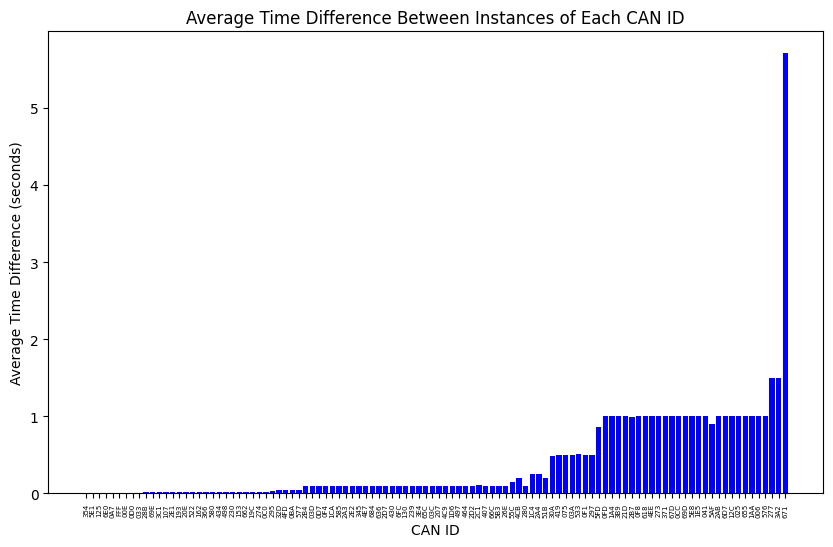

In [44]:
import matplotlib.pyplot as plt
from collections import defaultdict
import re

# ... (rest of the previous code to calculate average_time_diffs) ...

# Prepare data for plotting
can_ids = list(average_time_diffs.keys())
avg_time_diffs_values = list(average_time_diffs.values())

# Create a new figure
plt.figure(figsize=(10, 6))

# Create a bar plot
plt.bar(can_ids, avg_time_diffs_values, color='blue')

# Add labels and title
plt.xlabel('CAN ID')
plt.xticks(rotation=90)
plt.xticks(fontsize=5)
plt.ylabel('Average Time Difference (seconds)')
plt.title('Average Time Difference Between Instances of Each CAN ID')

# Rotate x labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.show()

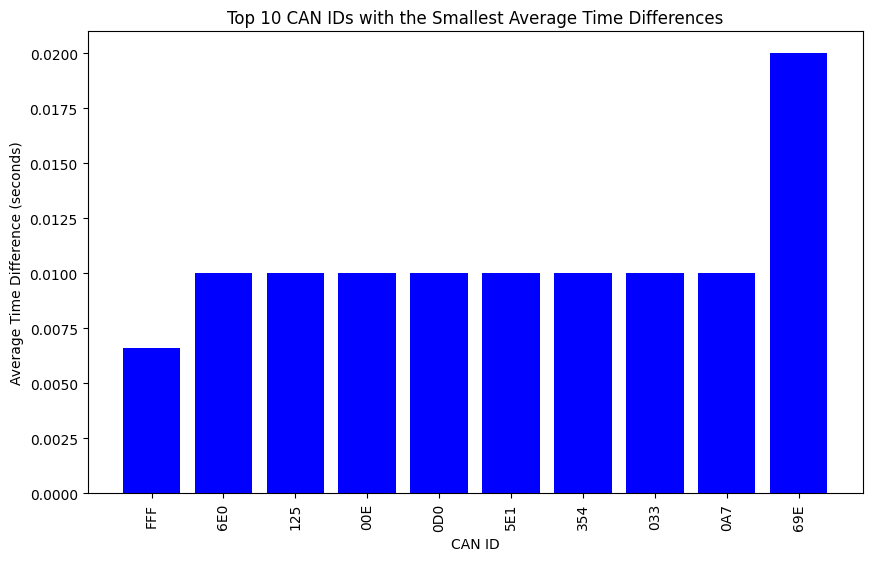

In [38]:
import matplotlib.pyplot as plt
from collections import defaultdict
import re


# ... (rest of the previous code to calculate average_time_diffs) ...

# Sort the CAN IDs based on their average time differences, and select the top 10
top_10 = sorted(average_time_diffs.items(), key=lambda x: x[1])[:10]

# Unpack the CAN IDs and average time differences for plotting
can_ids, avg_time_diffs_values = zip(*top_10)

# Create a new figure
plt.figure(figsize=(10, 6))

# Create a bar plot
plt.bar(can_ids, avg_time_diffs_values, color='blue')

# Add labels and title
plt.xlabel('CAN ID')
plt.xticks(rotation=90)
plt.ylabel('Average Time Difference (seconds)')
plt.title('Top 10 CAN IDs with the Smallest Average Time Differences')

# Show the plot
plt.show()
